In [114]:
import pandas as pd
import numpy as np
import nltk
import pyLDAvis.sklearn
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import string
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cheng\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [153]:
# import data
df = pd.read_csv('BCS_processed_audience_reviews.csv')[['rating_stars', 'season', 'review_text_processed']]

# 1. Sentiment Analysis : How do people like this TV show?

In [154]:
#sentiment analysis
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['review_text_processed'].apply(lambda x: sia.polarity_scores(x)['compound'])

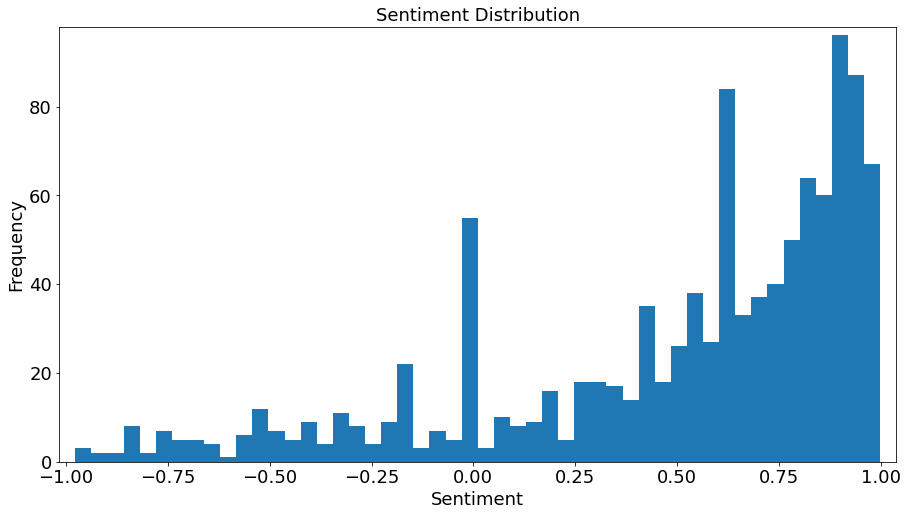

In [155]:
#histogram of sentiment scores
plt.figure(figsize=(15, 8))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.yticks(fontsize=18)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=18)
plt.show()

c:\Users\cheng\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '0.5'),
  Text(1, 0, '1.0'),
  Text(2, 0, '1.5'),
  Text(3, 0, '2.0'),
  Text(4, 0, '2.5'),
  Text(5, 0, '3.0'),
  Text(6, 0, '3.5'),
  Text(7, 0, '4.0'),
  Text(8, 0, '4.5'),
  Text(9, 0, '5.0')])

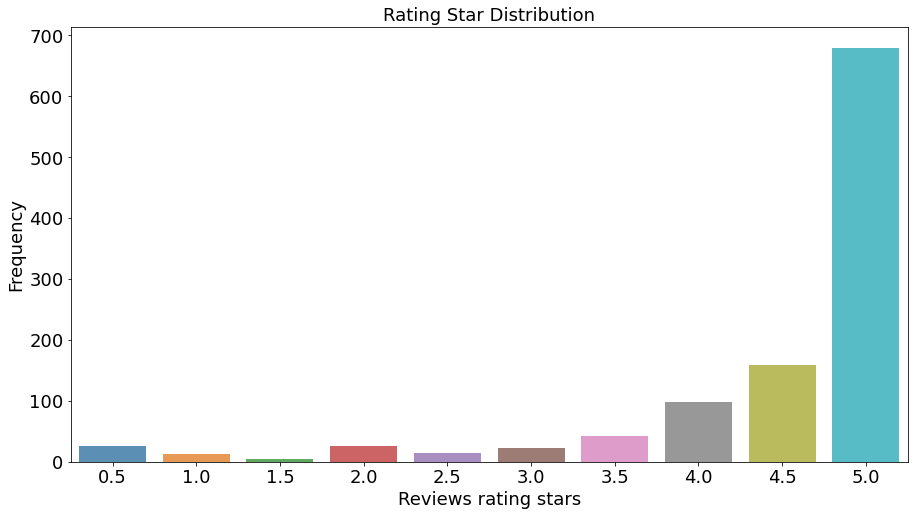

In [119]:
x_rating = df.rating_stars.value_counts()
plt.figure(figsize=(15,8))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Rating Star Distribution", fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Reviews rating stars', fontsize=18)
plt.xticks(fontsize=18)

<AxesSubplot:title={'center':'Percentage of Rating Stars'}, ylabel='rating_stars'>

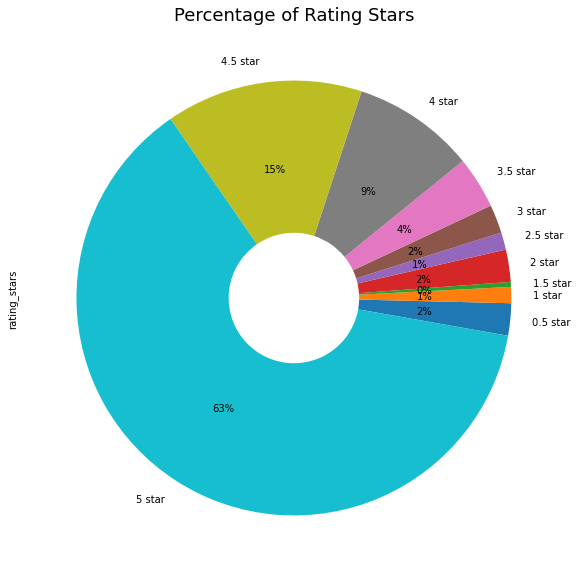

In [156]:
# pie chart
plt.figure(figsize=(20,10))
plt.title('Percentage of Rating Stars', fontsize=18)
df.rating_stars.value_counts().sort_index().plot(kind='pie', labels=['0.5 star', '1 star', '1.5 star', '2 star', '2.5 star',
                                                        '3 star', '3.5 star', '4 star', '4.5 star', '5 star'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -10, 
                              textprops={'fontsize':10})

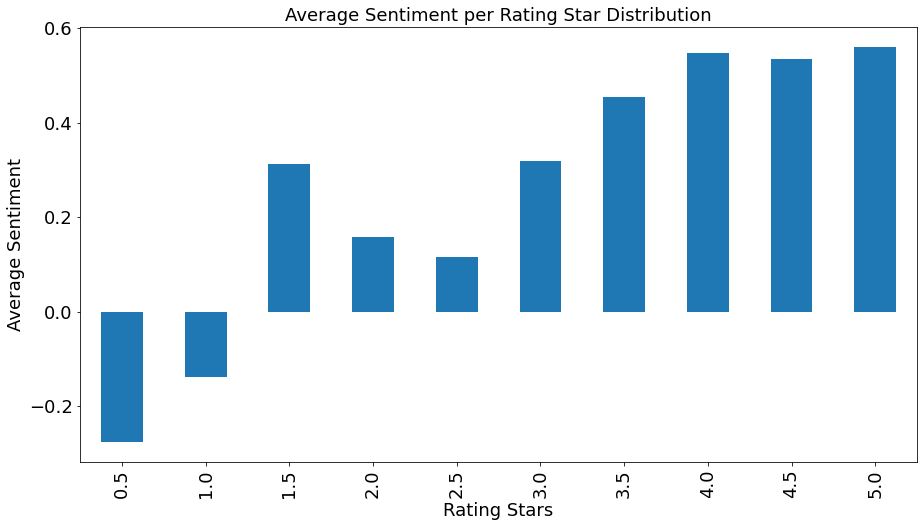

In [157]:
polarity_avg = df.groupby('rating_stars')['sentiment'].mean().plot(kind='bar', figsize=(15,8))
plt.xlabel('Rating Stars', fontsize=18)
plt.ylabel('Average Sentiment', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Average Sentiment per Rating Star Distribution', fontsize=18)
plt.show()

**Sentiment analysis is the process of determining the reviewer's attitude or opinion ranging from -1 (negative attitude) to 1 (positive attitude). After drawing a histogram of our sentiment, we can see that the vast majority of our derived sentiment scores is overwhelmingly positive. When we compare this against ``Rating stars'', we can see a similar pattern emerge. The majority of reviewers gave out over 4.5 stars to Better Call Saul. Not only do we feel confortable in the accuracy of the sentiment analysis but we can see that overall review attitude about the show is very positive.**

# 2. How much would people like to share?

In [158]:
df['word_count'] = df['review_text_processed'].apply(lambda x: len(x.split()))
df['letter_count'] = df['review_text_processed'].apply(lambda x: len(x.replace(' ','')))
df.head()

,rating_stars,season,review_text_processed,sentiment,word_count,letter_count
0,3.5,1,well call saul season 1 good nothing top show saul 's backstory throughout backstories find inte...,0.7723,45,240
1,5.0,1,good good prequel allah grant u prequels like,0.8689,8,38
2,2.0,1,like break bad except extremely boring unfunny,-0.5563,7,40
3,5.0,1,absolute brilliant season start show,0.5859,5,32
4,4.5,1,incredible write realistic performance make first season well call saul masterpiece however stil...,0.4019,18,114


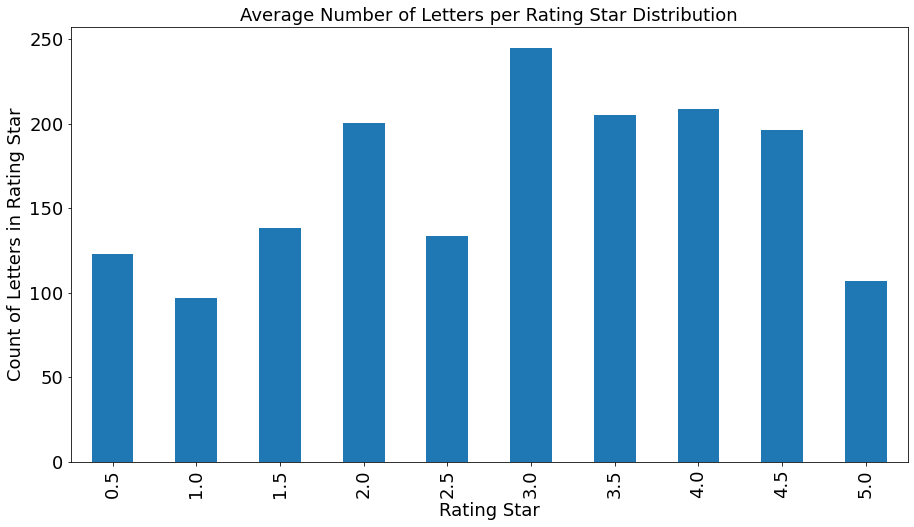

In [159]:
letter_avg = df.groupby('rating_stars')['letter_count'].mean().plot(kind='bar', figsize=(15,8))
plt.xlabel('Rating Star', fontsize=18)
plt.ylabel('Count of Letters in Rating Star', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Average Number of Letters per Rating Star Distribution', fontsize=18)
plt.show()

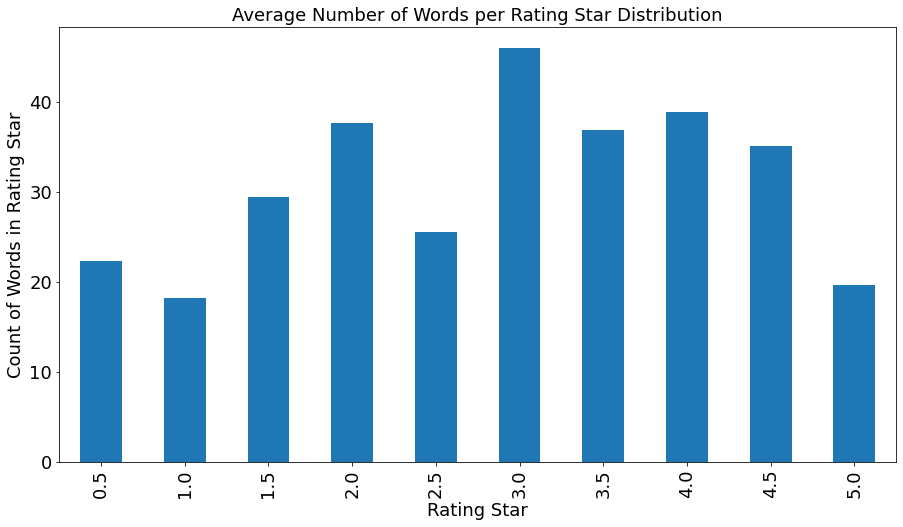

In [160]:
word_avg = df.groupby('rating_stars')['word_count'].mean().plot(kind='bar', figsize=(15,8))
plt.xlabel('Rating Star', fontsize=18)
plt.ylabel('Count of Words in Rating Star', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Average Number of Words per Rating Star Distribution', fontsize=18)
plt.show()

C:\Users\cheng\AppData\Local\Temp\ipykernel_20848\172176311.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation, dtype=np.bool)


<AxesSubplot:>

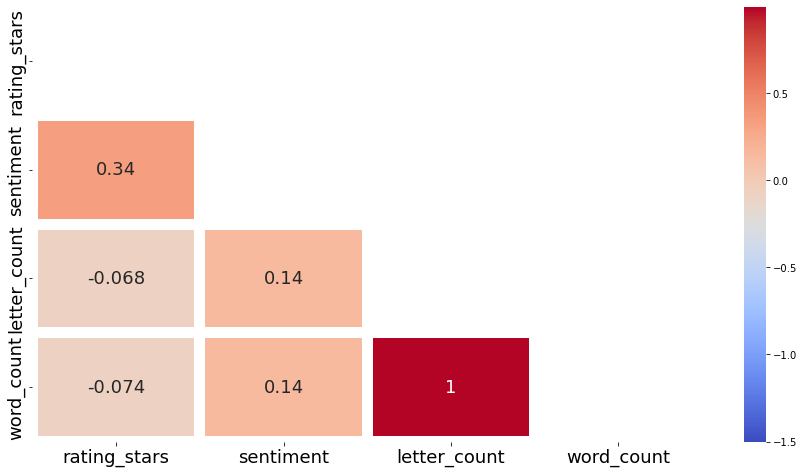

In [161]:
correlation = df[['rating_stars','sentiment', 'letter_count', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15,8))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 18}, linewidths=10, vmin=-1.5, mask=mask)

**In this section, we create two new features to capture how much people would like to share about their opinions on the show. These two features are *word_count* and *letter_count*. *word_count* determines the number of words per review and *letter_count* determines the number of letters per review.**

**Our analysis shows an interesting pattern. People who dislike (very low rating star) or love (very high rating star) tend to leave shorter reviews. People who somewhat like the show (3 -4.5 rating stars) tend to provide more detail in their reviews.**

**From the histograms, we know that the relationship between review length and ratings is unlikely to be a linear relationship. Therefore, it is not surprising that the correlation between review length and ratings is very samll in magnitude.**

**We also show the correlation between review length and sentiment score. Again, the correlation is rather small nevertheless positive.**

# 3. Term Frequency Analysis

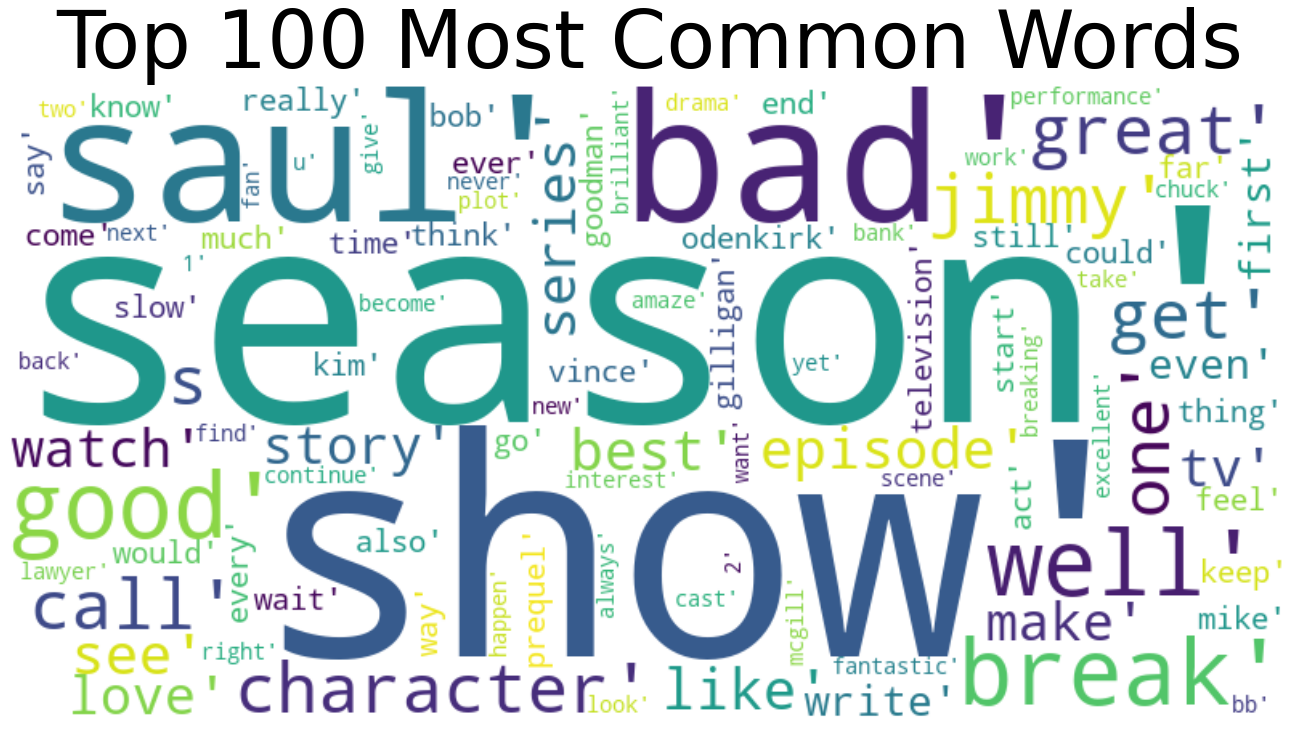

In [169]:
words = df['review_text_processed'].apply(lambda x: x.split())
allwords = []
for wordlist in words:
    allwords += wordlist

mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(str(mostcommon))

fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=80)
plt.tight_layout(pad=0)
plt.show()

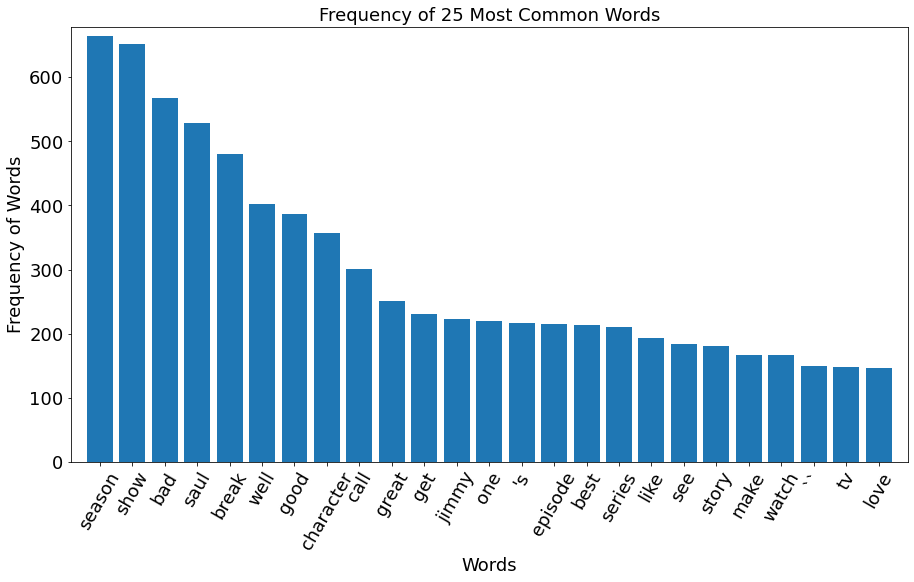

In [170]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(15,8))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=18)
plt.ylabel('Frequency of Words', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(rotation=60, fontsize=18)
plt.title('Frequency of 25 Most Common Words', fontsize=18)
plt.show()

**The results of the term frequency analysis certainly supports the overall positive sentiment of the reviews. Terms such as *fantastic*, *interest*, *character*, *performance* show that people enjoy the show.**

**One interesting finding here is that people are drawn to this show because of the TV show Breaking Bad. The high frequency of terms such as *break*, *bad* show that people tend to compare this show with Breaking Bad in their reviews.**

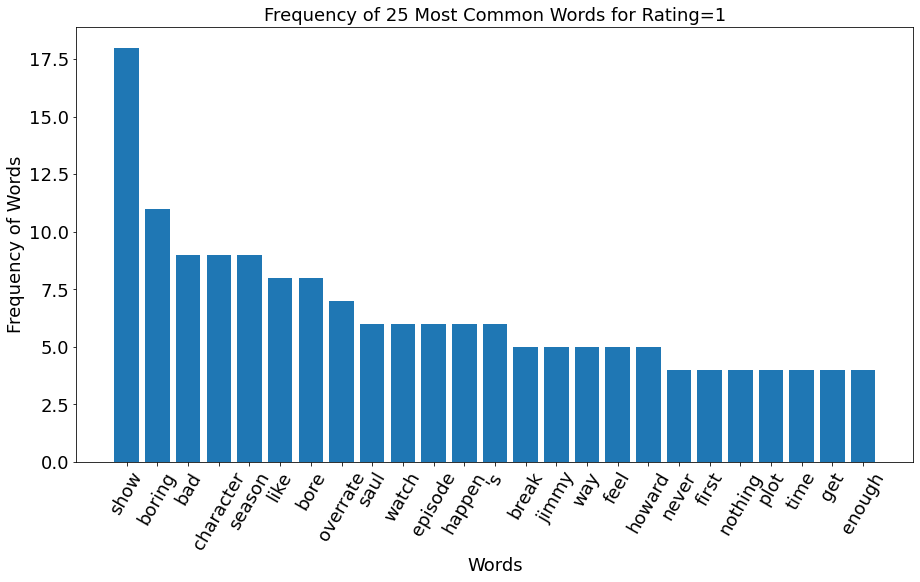

In [172]:
group_by = df.groupby('rating_stars')['review_text_processed'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[0]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(15,8))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=18)
plt.ylabel('Frequency of Words', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(rotation=60, fontsize=18)
plt.title('Frequency of 25 Most Common Words for Rating=0.5', fontsize=18)
plt.show()

**Despite the overall positve reviews, we still want to find out why some people dislike the show. We show the 25 most common words in reviews with only one rating star. It turns out people who do not enjoy the show because the think the show is boring and is overrated.**

# 4. Topic Modeling

In [173]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(df['review_text_processed'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

c:\Users\cheng\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,10,absolutely,act,actor,actually,almost,already,also,always,amaze,...,watch,way,well,whole,work,world,would,write,year,yet
0,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,0,0,0,0,0,0,0,0,0,1,...,0,0,3,0,0,0,0,0,0,0
1082,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1083,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1084,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [188]:
lda_model = LatentDirichletAllocation(n_components=5, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
best tv one show write series ever television odenkirk performance
Topic 1:
season well good episode saul first call get slow watch
Topic 2:
show great character love amaze act write fantastic gilligan every
Topic 3:
bad break saul good show well call character like series
Topic 4:
jimmy character saul show like mike season even story know


**We use the Latent Dirichlet Allocation (LDA) approach to determine 5 topics in our corpus and each topic consists of 10 words.**

**It certainly takes a little imagination to understand the topics produced by the LDA model.**

**Topic 0: Good storyline**

**Topic 1: Watched first episode**

**Topic 2: Great characters with good performance**

**Topic 3: good prequel to Breaking Bad**

**Topic 4: Jimmy and Mike are good characters on Better Call Saul**

In [189]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
panel

c:\Users\cheng\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\cheng\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\Users\cheng\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\cheng\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\cheng\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 's

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  29.782644
3       51.163364 -159.968018       2        1  28.041937
1      -73.144554   21.523815       3        1  20.375103
0      -66.410133 -110.606438       4        1  12.449559
2       54.417324   12.443444       5        1   9.350758, topic_info=       Term        Freq       Total Category  logprob  loglift
15      bad  559.000000  559.000000  Default  30.0000  30.0000
130  season  655.000000  655.000000  Default  29.0000  29.0000
24    break  468.000000  468.000000  Default  28.0000  28.0000
21     best  215.000000  215.000000  Default  27.0000  27.0000
137    show  651.000000  651.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
129   scene   11.761573   52.557898   Topic5  -4.8046   0.8726
146   story   38.484807  189.084266   Topic5  -3.6192   0.7778
164    well   39.700682  417.162498   Topic5  -3.5881   0.0176
162   watch   17.148137  165.065918   Topic5  -4.4275   0.1053
138    slow   12.830115  101.019755   Topic5  -4.7176   0.3062

[234 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         3  0.980185          10
1         4  0.442311  absolutely
1         5  0.537092  absolutely
2         1  0.059364         act
2         4  0.366076         act
...     ...       ...         ...
169       1  0.021119       write
169       4  0.591332       write
169       5  0.380142       write
170       1  0.507926        year
170       4  0.484838        year

[339 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 3])

**We also use pyLADvis to visualze how similar the topics are to each other and top-30 most relevant words for each topic.**

c:\Users\cheng\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([  0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

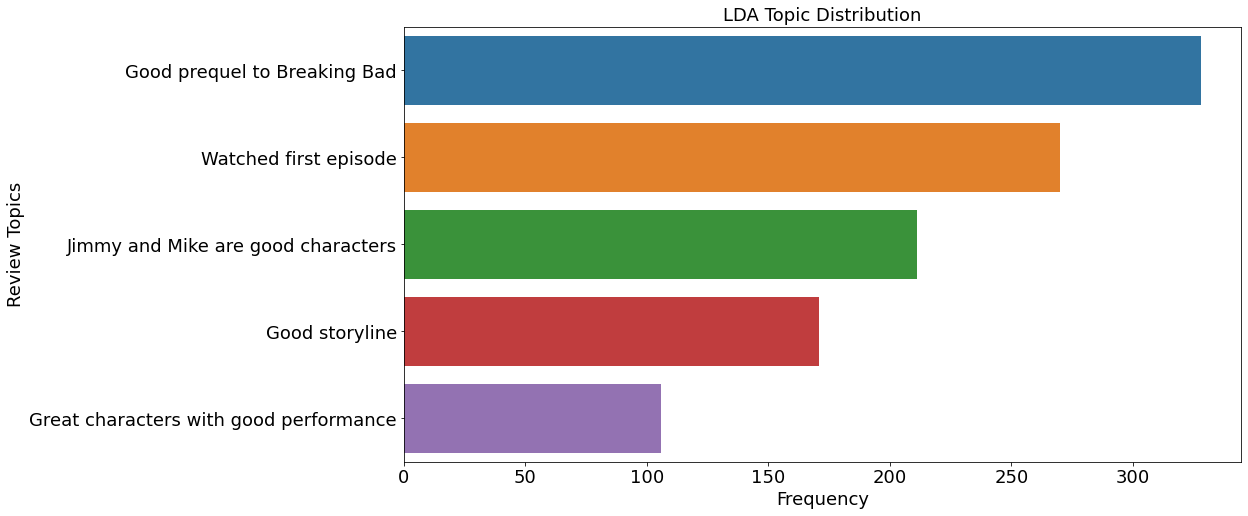

In [215]:
lda_topic_values = lda_model.transform(tf)
df['lda_topics'] = lda_topic_values.argmax(axis=1)
lda_remap = {0: 'Good storyline', 1: 'Watched first episode', 2: 'Great characters with good performance', 3: 'Good prequel to Breaking Bad',4: 'Jimmy and Mike are good characters'}
df['lda_topics'] = df['lda_topics'].map(lda_remap)

lda_x = df['lda_topics'].value_counts()
plt.figure(figsize=(15,8))
sns.barplot(lda_x.values, lda_x.index)
plt.title("LDA Topic Distribution", fontsize=18)
plt.ylabel('Review Topics', fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Frequency', fontsize=18)
plt.xticks(fontsize=18)

**We draw the distribution of LDA topics. Consistent with our findings from Word Cloud, most reviews mention the TV show Breaking Bad. It also seems that a lot reviews were posted after people watched the first episode.**

# 5. Which season do people like the most?

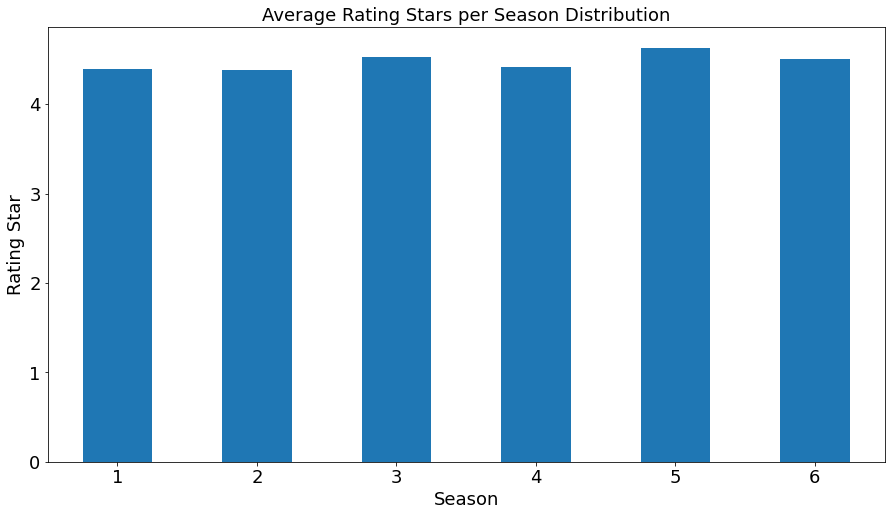

In [229]:
star_avg = df.groupby('season')['rating_stars'].mean().plot(kind='bar', figsize=(15,8))
plt.xlabel('Season', fontsize=18)
plt.ylabel('Rating Star', fontsize=18)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)
plt.title('Average Rating Stars per Season Distribution', fontsize=18)
plt.show()

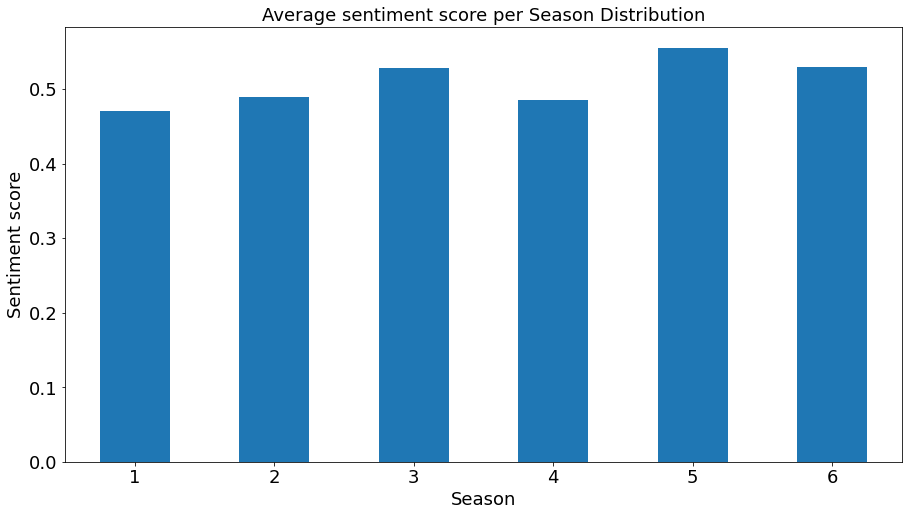

In [228]:
star_avg = df.groupby('season')['sentiment'].mean().plot(kind='bar', figsize=(15,8))
plt.xlabel('Season', fontsize=18)
plt.ylabel('Sentiment score', fontsize=18)
plt.xticks(rotation = 0, fontsize=18)
plt.yticks(fontsize=18)
plt.title('Average sentiment score per Season Distribution', fontsize=18)
plt.show()

**The average rating and average sentiment score is very similar across season 1 to 6, indicating that people do love every season of Better Call Saul.**